# Initialization

## Data Processing & Import Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["font.family"] = "serif"
% matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Waseda/4.3 Inaba Zemi/Senior Thesis/Data/"
df1 = pd.read_csv(path +'df_master_final.csv', index_col='date')
df1.index = pd.to_datetime(df1.index)

Mounted at /content/drive


In [2]:
df = df1.copy()
df = df.drop(columns={'Dead', 'PCR_negative', 'ComparisonPreDay', 'Tested\_MA(7days)', 'Severe\_Symptoms', 'Discharged', 'ComparisonPreSpread'})
#df.corr()['Positive\_Rate']
#df.columns

## 40 Days

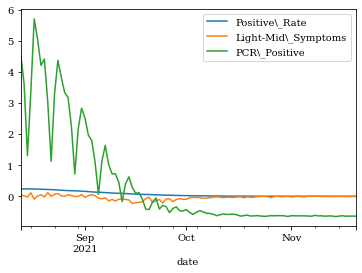

In [3]:
df_training = df[:-40].copy()
df_master = df.copy()

#Separate dates for future plotting
train_dates = pd.DataFrame(df_training.index)
predict_period_dates = pd.DataFrame(df_master[-40:].index)

#Variables for training
cols = list(df_master)[0:3]

df_for_training = df_training[cols].astype(float)
df_for_plot=df_for_training.tail(100)
df_for_plot.plot.line()

In [4]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
#We use all the columns because when we want to reinverse the data to get the original variable back, they espect us to input 5 columns.
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
trainX, trainY = np.array(trainX), np.array(trainY)

In [5]:
# define the Autoencoder model
model40 = Sequential()

# First Layer
model40.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

# Second Layer
model40.add(LSTM(512, return_sequences=True))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

# Third Layer
model40.add(LSTM(256, return_sequences=True))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

# Fourth Layer
model40.add(LSTM(64, return_sequences=False))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

# Output Layer
model40.add(Dense(trainY.shape[1]))

# Compile
model40.compile(optimizer='adam', loss='mse')

# fit the model
history40 = model40.fit(trainX, trainY, epochs=500, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/500


KeyboardInterrupt: ignored

In [ ]:
plt.plot(history40.history['loss'], label='Training loss')
plt.plot(history40.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('LSTM_Mult_NoHuman_40Days_Training.png', dpi=100)

In [ ]:
n_past = 40
n_days_for_prediction=40  #let us predict past 15 days
#Make prediction
prediction = model40.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

df_forecast = pd.DataFrame({'date':predict_period_dates.values.T[0], 'Positive\_Rate':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])
df_forecast.index = df_forecast['date']
df_forecast = df_forecast.drop(columns={'date'})

original = pd.DataFrame(df_master['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df_master['Positive\_Rate'][-100:-40])
df_pred_plot = pd.concat([original_pred, df_forecast])
df_pred_plot.to_csv("LSTM_Mult_NoHuman_40days.csv")

rmse = sqrt(mean_squared_error(df_forecast, original[-40:]))
print(rmse)

In [ ]:
sns.lineplot(data=original, x=original.index, y=original['Positive\_Rate'])
sns.lineplot(data=df_pred_plot, x=df_pred_plot.index, y=df_pred_plot['Positive\_Rate'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')
plt.legend(['Real Data', 'Predicted Data'])
plt.savefig('LSTM_Mult_NoHuman_40Days.png', dpi=100)

## 20 Days

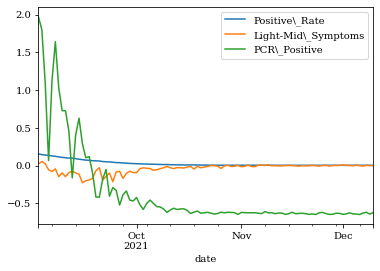

In [6]:
df_training = df[:-20].copy()
df_master = df.copy()

#Separate dates for future plotting
train_dates = pd.DataFrame(df_training.index)
predict_period_dates = pd.DataFrame(df_master[-20:].index)

#Variables for training
cols = list(df_master)[0:3]

df_for_training = df_training[cols].astype(float)
df_for_plot=df_for_training.tail(100)
df_for_plot.plot.line()

In [7]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
#We use all the columns because when we want to reinverse the data to get the original variable back, they espect us to input 5 columns.
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 7  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
trainX, trainY = np.array(trainX), np.array(trainY)

In [8]:
# define the Autoencoder model
model20 = Sequential()

# First Layer
model20.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model20.add(LeakyReLU(alpha=0.181818))

# Second Layer
model20.add(LSTM(512, return_sequences=True))
model20.add(LeakyReLU(alpha=0.181818))
model20.add(Dropout(0.4))

# Third Layer
model20.add(LSTM(256, return_sequences=True))
model20.add(LeakyReLU(alpha=0.181818))
model20.add(Dropout(0.4))

# Fourth Layer
model20.add(LSTM(64, return_sequences=False))
model20.add(LeakyReLU(alpha=0.181818))

# Output Layer
model20.add(Dense(trainY.shape[1]))
model20.compile(optimizer='adam', loss='mse')

# fit the model
history20 = model20.fit(trainX, trainY, epochs=500, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/500
9/9 [==============================] - 12s 475ms/step - loss: 0.7625 - val_loss: 0.1569
Epoch 2/500
9/9 [==============================] - 2s 265ms/step - loss: 0.1611 - val_loss: 0.5310
Epoch 3/500
9/9 [==============================] - 2s 264ms/step - loss: 0.1042 - val_loss: 0.3481
Epoch 4/500
9/9 [==============================] - 2s 266ms/step - loss: 0.0948 - val_loss: 0.2038
Epoch 5/500
9/9 [==============================] - 2s 260ms/step - loss: 0.0683 - val_loss: 0.1029
Epoch 6/500
9/9 [==============================] - 2s 259ms/step - loss: 0.0910 - val_loss: 0.0509
Epoch 7/500
9/9 [==============================] - 2s 265ms/step - loss: 0.0863 - val_loss: 0.0391
Epoch 8/500
9/9 [==============================] - 2s 273ms/step - loss: 0.0636 - val_loss: 0.0878
Epoch 9/500
9/9 [==============================] - 2s 274ms/step - loss: 0.0516 - val_loss: 0.0613
Epoch 10/500
9/9 [==============================] - 2s 271ms/step - loss: 0.0494 - val_loss: 0.0197
Epoch 11

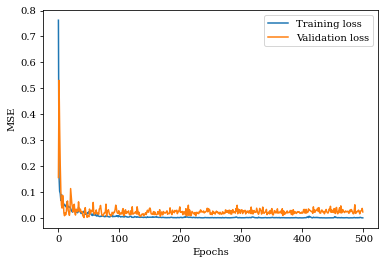

In [9]:
plt.plot(history20.history['loss'], label='Training loss')
plt.plot(history20.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('LSTM_Mult_NoHuman_20Days_Training.png', dpi=100)

In [10]:
n_past = 20
n_days_for_prediction=20  #let us predict past 15 days
#Make prediction
prediction = model20.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

df_forecast = pd.DataFrame({'date':predict_period_dates.values.T[0], 'Positive\_Rate':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])
df_forecast.index = df_forecast['date']
df_forecast = df_forecast.drop(columns={'date'})

original = pd.DataFrame(df_master['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df_master['Positive\_Rate'][-100:-20])
df_pred_plot = pd.concat([original_pred, df_forecast])
df_pred_plot.to_csv("LSTM_Mult_NoHuman_20days.csv")

rmse = sqrt(mean_squared_error(df_forecast, original[-20:]))
print(rmse)

0.0065467272433906085


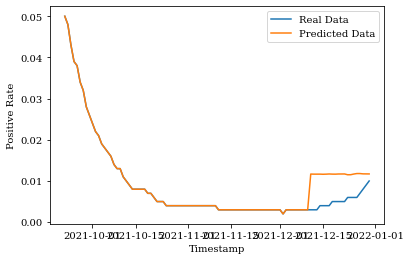

In [11]:
sns.lineplot(data=original, x=original.index, y=original['Positive\_Rate'])
sns.lineplot(data=df_pred_plot, x=df_pred_plot.index, y=df_pred_plot['Positive\_Rate'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')
plt.legend(['Real Data', 'Predicted Data'])
plt.savefig('LSTM_Mult_NoHuman_20Days.png', dpi=100)

## 80 Days

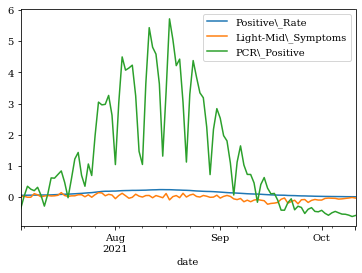

In [12]:
df_training = df[:-80].copy()
df_master = df.copy()

#Separate dates for future plotting
train_dates = pd.DataFrame(df_training.index)
predict_period_dates = pd.DataFrame(df_master[-80:].index)

#Variables for training
cols = list(df_master)[0:3]

df_for_training = df_training[cols].astype(float)
df_for_plot=df_for_training.tail(100)
df_for_plot.plot.line()

In [13]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
#We use all the columns because when we want to reinverse the data to get the original variable back, they espect us to input 5 columns.
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 21  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
trainX, trainY = np.array(trainX), np.array(trainY)

In [14]:
# define the Autoencoder model
model80 = Sequential()

# First Layer
model80.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model80.add(LeakyReLU(alpha=0.181818))

# Second Layer
model80.add(LSTM(512, return_sequences=True))
model80.add(LeakyReLU(alpha=0.181818))
model80.add(Dropout(0.4))

# Third Layer
model80.add(LSTM(256, return_sequences=True))
model80.add(LeakyReLU(alpha=0.181818))
model80.add(Dropout(0.4))

# Fourth Layer
model80.add(LSTM(64, return_sequences=False))
model80.add(LeakyReLU(alpha=0.181818))

# Output Layer
model80.add(Dense(trainY.shape[1]))
model80.compile(optimizer='adam', loss='mse')
model80.summary()

# fit the model
history80 = model80.fit(trainX, trainY, epochs=500, batch_size=64, validation_split=0.1, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 21, 128)           67584     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 21, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 21, 512)           1312768   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 21, 512)           0         
                                                                 
 dropout_6 (Dropout)         (None, 21, 512)           0         
                                                                 
 lstm_10 (LSTM)              (None, 21, 256)           787456    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 21, 256)          

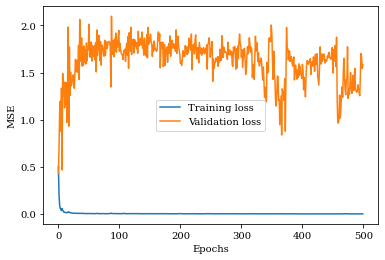

In [15]:
plt.plot(history80.history['loss'], label='Training loss')
plt.plot(history80.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('LSTM_Mult_NoHuman_80Days_Training.png', dpi=100)

In [16]:
n_past = 80
n_days_for_prediction=80  #let us predict past 15 days
#Make prediction
prediction = model80.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

df_forecast = pd.DataFrame({'date':predict_period_dates.values.T[0], 'Positive\_Rate':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])
df_forecast.index = df_forecast['date']
df_forecast = df_forecast.drop(columns={'date'})

original = pd.DataFrame(df_master['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df_master['Positive\_Rate'][-100:-80])
df_pred_plot = pd.concat([original_pred, df_forecast])
df_pred_plot.to_csv("LSTM_Mult_NoHuman_80days.csv")

rmse = sqrt(mean_squared_error(df_forecast, original[-80:]))
print(rmse)

0.17771190989719718


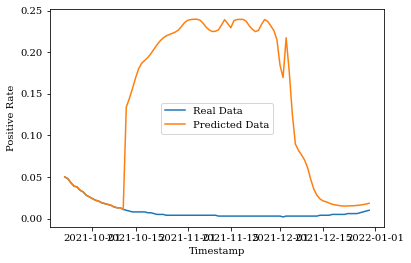

In [17]:
sns.lineplot(data=original, x=original.index, y=original['Positive\_Rate'])
sns.lineplot(data=df_pred_plot, x=df_pred_plot.index, y=df_pred_plot['Positive\_Rate'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')
plt.legend(['Real Data', 'Predicted Data'])
plt.savefig('LSTM_Mult_NoHuman_80Days.png', dpi=100)